### MNIST 데이터
- 0 ~ 9까지 숫자로 이루어진 이미지 데이터
- 28x28 행렬 크기로 구성
- 1에 가까울 수록 흰색, 0에 가까울 수록 검은색 픽셀
- One-Hot Encoding 방식으로 레이블 10인 벡터 구성
    - 4의 경우 [0,0,0,0,1,0,0,0,0,0]
- 눈에 보기에는 2차원 행렬 데이터지만 실제 3차원 데이터
    - [1, 28, 28] 형태 [Channel, Width, Height] 
    - Channel - 이미지 색상정보. 보통 컬러이미지면 R,G,B로 3채널 사용
    - 컬러 였다면 [3, 28, 28] 형태

### 손글씨 이미지 분류
- 간단한 구조의 CNN 구현
- 코드 구성
    1. 모듈 및 분석환경 설정
    2. 데이터 불러오기
    3. 모델 학습
    4. 모델 평가

#### 모델 불러오기

In [24]:
import torch                                        # PyTorch 기본 라이브러리
import torch.nn as nn                               # Neural Network의 약자. 딥러닝 네트워크 기본 구성요소
import torch.nn.functional as F                     # 자주 사용하는 함수 모듈
import torch.optim as optim                         # 가중치 추정에 필요한 최적화 알고리즘 포함
from torchvision import datasets, transforms        # 이미지 데이터셋과 이미지 변환함수 포함

from matplotlib import pyplot as plt                # 차트 시각화 모듈
# 주피터를 브라우저에서 사용할 때 사용, VS Code는 사실상 불필요
%matplotlib inline                              

from tqdm.autonotebook import tqdm # 프로그래스바 시각화 모듈

C:\Users\perso\AppData\Local\Temp\ipykernel_27596\1628159743.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm # 프로그래스바 시각화 모듈


#### 분석환경 설정

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(f'Current cuda device is {device}')
# GPU - cuda, CPU - cpu

Current cuda device is cuda


#### 하이퍼파라미터 지정

In [4]:
batch_size = 50                                     # 미니배치 사이즈
epoch_num = 15                                      # 학습데이터를 모두 사용하는 한 단위
learning_rate = 0.0001                              # 가중치 업데이트 정도

#### MNIST 데이터 로드

In [ ]:
# root - 로컬 저장위치, train - 데이터학습용 여부, download - 처음 시행된것이 아니면 False
# transform - 저장과 동시에 전처리를 할 수 있는 옵션. 이미지를 Tensor로 변형하는 transform.ToTensor() 사용
train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())

print(f'train data# {len(train_data)}, test data# {len(test_data)}')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.65MB/s]


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.70MB/s]


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.00MB/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw

train data# 60000, test data# 10000


#### MNIST 데이터 확인

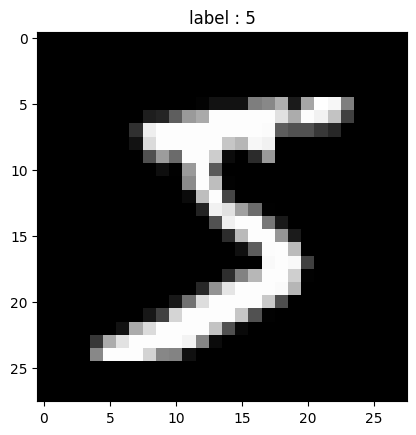

In [7]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'label : {label}')
plt.show()

#### 미니배치 구성

In [19]:
# dataset - 미니배치로 구성할 데이터, batch_size - 미니배치 사이즈 지정, shuffle - 데이터 순서를 랜덤으로 섞을지 여부
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

first_batch = train_loader.__iter__().__next__()

print(f'{"name":15s} | {"type":<25s} | {"size"}')
# 1200개 미니배치 60000 / 50 
print(f'{"Num of Batch":15s} | {"":<25s} | {len(train_loader)}')
# 각 배치는 두개의 배열로 구성
print(f'{"first_batch":15s} | {str(type(first_batch)):<25s} | {len(first_batch)}')
# 첫 요소 - 4차원 텐서. [BatchSize, Channel, Width, Height], 3차원에 배치 추가
print(f'{"first_batch[0]":15s} | {str(type(first_batch[0])):<25s} | {first_batch[0].shape}')
# 두번째 요소 - 50사이즈 벡터. 미니배치 정답 저장
print(f'{"first_batch[1]":15s} | {str(type(first_batch[1])):<25s} | {first_batch[1].shape}')

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


#### 모델 학습

- [Channel = 1, Width = 28, Height = 28] 입력 텐서에 Filter = 1, Filter W = 3, Filter H = 3이 필터를 32개 사용하는 첫번째 Convolution Layer를 통과하면 [Channel =32, Width = 26, Height = 26] 텐서 출력.
- nn.Conv2d() padidng = 0, stride = 1 기본값 사용, Filter Size = 3

$$ 0 = \frac{I + 2P - F}{S} + 1 = \frac {28 + 2 \times 0 - 3} {1} + 1 = 26 $$

- MaxPooling 경우 텐서의 가로, 세로에만 영향을 줌. [64, 24, 24] 에서 [64, 12, 12] 로 반감
- Flatten 연산 Fully-connected Layer 연산을 위해 고차원 텐서를 1차원으로 줄이는 것. 3차원 9,216길에 텐서를 1차원 벡터로 변환
- MNIST 10개의 클래스 (0 ~ 9)

<img src="../images/torch0028.png" width="500">

#### CNN 구조 설계

In [20]:
class CNN(nn.Module):                           # nn.Module을 상송받는 CNN 클래스 선언
    def __init__(self):                     
        super(CNN, self).__init__()             # super()로 nn.Module 클래스의 속성을 상속후 초기화
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     # In channel 1, Out channel 32, kernel  3, stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    # In channel 32, Out channel 64, kernel 3, stride 1
        self.dropout1 = nn.Dropout2d(0.25)      # Dropout 확률 0.25
        self.dropout2 = nn.Dropout2d(0.5)       # Dropout 확률 0.5
        self.fc1 = nn.Linear(9216, 128)         # Fully Connected layer  9216 벡터를 128 벡터로 변환
        self.fc2 = nn.Linear(128, 10)           # FC2, 128 벡터를, 10 출력 벡터로 

    def forward(self, x):                       # Feed Forward 연산 정의
        x = self.conv1(x)                       # conv1 레이어 통과
        x = F.relu(x)                           # ReLU 활성함수 적용
        x = self.conv2(x)                       # conv2 레이어 통과
        x = F.relu(x)                           # ReLU 활성함수 적용
        x = F.max_pool2d(x, 2)                  # (2x2)필터로 Max Poolling 적용
        x = self.dropout1(x)                    # 0.25확률 dropout1 반영
        x = torch.flatten(x, 1)                 # 고차원 텐서를 1차원 벡터로 변환 [64,12,12]
        x = self.fc1(x)                         # 9216 벡터를 128벡터로 학습하는 fc1 통과
        x = F.relu(x)                           # ReLU 활성함수 적용
        x = self.dropout2(x)                    # 0.5확률의 dropout2 반영
        x = self.fc2(x)                         # 128벡터가 10벡터로 변경 fc2 통과
        output = F.log_softmax(x, dim=1)        # 최종 출력값을 log-softmax로 계산. Softmax보다 연산속도 높음
        return output

#### Optimizer 및 손실함수 정의

In [ ]:
model = CNN().to(device=device)                                 # CNN 클래스 인스턴스 생성. GPU 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate)    # 손실함수로 Adam 알고리즘 사용
criterion = nn.CrossEntropyLoss()                               # 다중 클래스 문제로 Cross Entropy를 손실함수로 설정(criterion - 기준)

#### CNN 모형 확인

In [22]:
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### 모델학습

In [28]:
model.train()                                                       # CNN클래스로 정의된 model 인스턴스를 학습모드로 실행 명시
i = 0                                                               # 반복학습 중 손실함수 현황 확인위해 학습횟수를 나타내는 보조 인덱스

for epoch in tqdm(range(epoch_num + 1)):                            # 미리 지정된 epoch수(15)만큼 for 문 수행
    for data, target in train_loader:                               # batch_size로 나눈만큼 반복 수행, train_loader는 매 시행마다 미니배치 데이터,정답 할당
        data = data.to(device)                                      # 미니배치 데이터를 device에 할당
        target = target.to(device)                                  # 미니배치 정답을 device에 할당

        optimizer.zero_grad()                                       # optimizer의 gradient(기울기) 초기화
        output = model(data)                                        # 모델을 통과시킴. conv1.... log_softmax
        loss = criterion(output, target)                            # 계산결과와 정답으로 손실함수 계산
        loss.backward()                                             # 손실함수를 통해 gradient계산(역전파)
        optimizer.step()                                            # 계산된 gradient로 모델의 가중치 업데이트

        if i % 1000 == 0:                                           # 1000번 실행마다 손실함수 값 확인
            print(f'Train Step: {i:<10d}\tLoss: {loss.item():.3f}')
        i += 1                                                      # 학습완료 후 보조인덱스 1증가

  0%|          | 0/16 [00:00<?, ?it/s]

Train Step: 0         	Loss: 0.055
Train Step: 1000      	Loss: 0.063


  6%|▋         | 1/16 [00:18<04:31, 18.13s/it]

Train Step: 2000      	Loss: 0.008


 12%|█▎        | 2/16 [00:35<04:11, 17.93s/it]

Train Step: 3000      	Loss: 0.024


 19%|█▉        | 3/16 [00:53<03:51, 17.84s/it]

Train Step: 4000      	Loss: 0.010


 25%|██▌       | 4/16 [01:11<03:35, 17.93s/it]

Train Step: 5000      	Loss: 0.046


 31%|███▏      | 5/16 [01:29<03:16, 17.89s/it]

Train Step: 6000      	Loss: 0.008
Train Step: 7000      	Loss: 0.280


 38%|███▊      | 6/16 [01:47<02:58, 17.81s/it]

Train Step: 8000      	Loss: 0.012


 44%|████▍     | 7/16 [02:05<02:40, 17.81s/it]

Train Step: 9000      	Loss: 0.014


 50%|█████     | 8/16 [02:22<02:22, 17.86s/it]

Train Step: 10000     	Loss: 0.023


 56%|█████▋    | 9/16 [02:40<02:04, 17.84s/it]

Train Step: 11000     	Loss: 0.009


 62%|██████▎   | 10/16 [02:58<01:47, 17.85s/it]

Train Step: 12000     	Loss: 0.071
Train Step: 13000     	Loss: 0.008


 69%|██████▉   | 11/16 [03:16<01:29, 17.85s/it]

Train Step: 14000     	Loss: 0.003


 75%|███████▌  | 12/16 [03:34<01:11, 17.90s/it]

Train Step: 15000     	Loss: 0.025


 81%|████████▏ | 13/16 [03:52<00:53, 17.85s/it]

Train Step: 16000     	Loss: 0.015


 88%|████████▊ | 14/16 [04:10<00:35, 17.86s/it]

Train Step: 17000     	Loss: 0.030


 94%|█████████▍| 15/16 [04:28<00:17, 17.87s/it]

Train Step: 18000     	Loss: 0.001
Train Step: 19000     	Loss: 0.055


100%|██████████| 16/16 [04:45<00:00, 17.86s/it]


#### 모델평가

In [ ]:
model.eval()                                                        # 평가모드
correct = 0                                     
for data, target in test_loader:                                    # 미니배치 데이터와 정답을 data와 target에 저장
    data = data.to(device)
    target = target.to(device)
    output = model(data)                                            # 모델 통과 결과값 계산
    prediction = output.data.max(1)[1]                              # log-softmax값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum()                     # 예측값이 같으면 True, 아니면 False를 논리값 벡터에 더함

print(f'Test set: Accuracy: {(100 * correct / len(test_loader.dataset)):.2f}')

Test set: Accuracy: 99.26
